<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 5 &ndash; Drug Discovery</h2>

<b>Authors:</b> S. Luukkonen (adapted from B. Schäfl, S. Lehner, J. Schimunek, J. Brandstetter, E. Kobler, A. Schörgenhumer)<br>
<b>Date:</b> 03-05-2024

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>

This notebook is designed to run from start to finish. There are different tasks (displayed in <span style="color:rgb(248,138,36)">orange boxes</span>) which might require small code modifications. Most/All of the used functions are imported from the file <code>u5_utils.py</code> which can be seen and treated as a black box. However, for further understanding, you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>u5_utils.py</code> need to be installed. One new package is required: <code>rdkit</code> (install with, e.g., <code>pip install rdkit</code>)

In [17]:
# Import pre-defined utilities specific to this notebook.
import u5_utils as u5

# Import additional utilities needed in this notebook.
import numpy as np
import pandas as pd
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator 

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import ParameterGrid

from IPython.display import SVG

# Set default plotting style.
sns.set()

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u5.setup_jupyter()

In [18]:
%reload_ext autoreload
%autoreload 2

<h3 style="color:rgb(0,120,170)">Module versions</h3>

As mentioned in the introductory slides, specific minimum versions of Python itself as well as of used modules are recommended.

In [19]:
u5.check_module_versions()

Installed Python version: 3.10 (✓)
Installed numpy version: 1.26.4 (✓)
Installed pandas version: 2.2.1 (✓)
Installed scikit-learn version: 1.3.1 (✓)
Installed matplotlib version: 3.8.3 (✓)
Installed seaborn version: 0.13.0 (✓)
Installed PIL version: 9.0.1 (✓)
Installed rdkit version: 2023.09.6 (✓)


<a name="qsar"></a><h2 style="color:rgb(0,120,170)">Quantitative structure-activity relationship</h2>

The drug discovery process is inherently a multi-objective optimization problem, but at the core of early-stage drug discovery is to find ligands, <i>i.e.</i> the potential drug candidates – typically small organic molecules –, that bind strongly to the biological target – typically a protein such as an enzyme or receptor. The bioactivity of a compound, <i>i.e.</i> if it binds to the targets – or affects its functioning –, is determined by time- and cost-intensive in vitro assays.

The <i>Quantitative struture-activity relationship</i> (QSAR) postulates that the biological activity of a compound is a function of its chemical structure.  More concretely, the aim of QSAR is to find this function to have model for biological activity:

<div align="center">
<img src="resources/qsar.png" alt="Image not found!" width="250px"/>
</div>

Certainly, while this postulate is quite intuitively true, it comes with two problems: a) to find a <i>numerical representation of a molecule</i>, and b) to <i>find a function</i> that maps this numerical representation to an activity. If you manange to create a good model mapping molecules to their activity, this can be used in <i>Virtual Screening</i> to select promising drug candidates from virtual libraries with upto millions of molecules for next stages to drug discovery process.

<a name="rdkit"></a><h2 style="color:rgb(0,120,170)">RDkit - community effort for cheminformatics</h2>

<a href="https://rdkit.org/"><tt>RDkit</tt></a> is an open source <tt>Python</tt> package to hadle small molecules (a counter partern for large biomolecules, *e.g.*, proteins and DNA, would be <a href="https://biopython.org/"><tt>Biopython</tt></a>). It is a community effort, hence there are many users working with it. This in turn leads to lot to some bugs and other problem, and relativily poor <a href="https://www.rdkit.org/docs/api-docs.html">official documentation</a> but you'll find helpful information in diverse forums or the <a href="https://greglandrum.github.io/rdkit-blog/">Greg Landrum's RDkit blog</a>.

<tt>RDkit</tt> will be our main tool in this notebook.


<a name="mutag"></a><h2 style="color:rgb(0,120,170)">The MUTAG dataset</h2>

The MUTAG dataset is as small dataset of over 200 molecules tested for mutagenicity (inducing mutations in DNA). More information about the dataset can be found in this publication: <br>

<div align="center">
<i> Debnath, A. K., Lopez de Compadre, R. L., Debnath, G., Shusterman, A. J., & Hansch, C. (1991). Structure-activity relationship of mutagenic aromatic and heteroaromatic nitro compounds. correlation with molecular orbital energies and hydrophobicity. Journal of medicinal chemistry, 34(2), 786-797. </i>
</div>

In the following we will load this dataset in **MOL/SDF format** and inspect it in more detail. The main blocks of this data format are depicted below:

<div align="center">
<br>
<img src="resources/sdf_format.gif" width="400"/> <br>
Source: http://www.homepages.ed.ac.uk/jjarvis/research/thesis/node50.html 
</div>

Lets load the dataset with rdkit:

In [20]:
data_mutag = Chem.SDMolSupplier('resources/mutag.sdf')
print(f'{len(data_mutag)} molecules loaded from file.')

218 molecules loaded from file.


and take a look a the first entry. Specific molecules can be simply selected using the well-known Python indexing mechanics – with the exception that only <i>single</i> integer indices are allowed (e.g., no <i>slices</i>). 

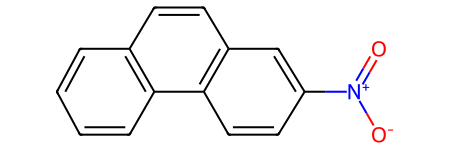

In [21]:
mol0 = data_mutag[0]
mol0

Here we have visual representation of the molecular graph and several additional properties of the molecules.
- Name 
- Chemical formula
- Several physicochemical properties: [logP](https://en.wikipedia.org/wiki/Partition_coefficient) (the partition coefficient between water and octanol) and LUMO (lowest unoccupied molecular obrital)
- Bioactivity in mutagenisis test

Every molecule may be annotated by various properties. A list of all property names of a molecule can be extracted by <code>GetPropNames</code>, whereas a specific property value by <code>GetProp</code> and the corresponding <i>property name</i>. This in combination with the previously discussed plotting functionality acts as an easy but effective mechanism to get a quick overview of the molecules at hand.</p>

In [22]:
list(mol0.GetPropNames())

['Compound Name', 'Formula', 'LogP', 'LUMO', 'MOL_ID', 'Activity']

In [23]:
print(f'The molecule "{mol0.GetProp("Compound Name")}" '
      f'with the formula "{mol0.GetProp("Formula")}" '
      f'has an activity of "{mol0.GetProp("Activity")}".')

The molecule "2-nitrophenanthrene" with the formula "C14H9NO2" has an activity of "2.11".


<p>If more detailed information about the molecular structure of a specified molecule is needed, the corresponding <code>MolToMolBlock</code> call delivers exactly that. The resulting ouput should already look quite familiar, if not, have a look at <a href="resources/mutag.sdf">resources/mutag.sfd</a> file.</p>

In [24]:
print(Chem.MolToMolBlock(mol0))

2-nitrophenanthrene
     RDKit          2D

 17 19  0  0  0  0  0  0  0  0999 V2000
    0.6533    2.4267    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    1.2133    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.6533   -0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.0533   -0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.7533    1.2133    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.0533    2.4267    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    4.1533    1.2133    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    4.8533    2.4267    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    4.1533    3.5933    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.7533    3.5933    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    4.8533   -0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    6.2533   -0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    7.0000    1.2133    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    6.

<a name="molecule-data-nutshell"></a><h2 style="color:rgb(0,120,170)">Small molecule representation</h2>

A **molecule** is a group of two or more atoms held together by attractive forces known as chemical bonds. In the physical world, molecules manifest as three-dimensional structures composed of nuclei surrounded by shared electrons, which are responsible for the molecule's stability and reactivity. There are various methods for representing molecules, each offering insights into their structure and behavior:

<div align="center">
<img src="resources/molecule_representations.png" alt="Image not found!" width="1000px"/>
</div>

In this unit we will, we will focus on three small molecule representations:
- Molecular graphs
- SMILES
- Molecular fingerprints.

In [25]:
# Helper function to draw molecules

def draw_molecule(mol, bond_idcs=False, atom_idcs=False, explicit_hydrogens=False):
    """Draw molecular structure with node numbering and explicit hydrogens"""    
    if explicit_hydrogens:
        mol = Chem.AddHs(mol, addCoords=True)
    
    AllChem.Compute2DCoords(mol)
    d2d = Chem.Draw.MolDraw2DSVG(350, 300)
    d2d.drawOptions().addAtomIndices = atom_idcs
    d2d.drawOptions().addBondIndices = bond_idcs
    d2d.drawOptions().annotationFontScale = 0.75
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    return SVG(d2d.GetDrawingText())

<h3 style="color:rgb(0,120,170)">Molecular graphs</h3>

A **molecular graph**, or chemical graph, is a representation of the structural formula of a chemical compound in terms of graph theory. A chemical graph is a *undirected labeled graph* whose vertices correspond to the *atoms* of the compound and edges correspond to chemical *bonds*. Its vertices are labeled with the kinds of the corresponding atoms and edges are labeled with the types of bonds.

Nodes "without labels" correspond to carbon atoms and typically *hydrogen-depleted molecular graph* are used where the hydrogen vertices deleted, but they are nonetheless implied.

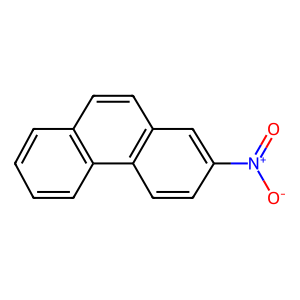

In [26]:
Chem.Draw.MolToImage(mol0)

The number and position of the hydrogen atoms can be deducted based on valance rules of the heavy atoms (=any non-hydrogen atom), and be added to the molecule with the <code>AddHs</code> method.

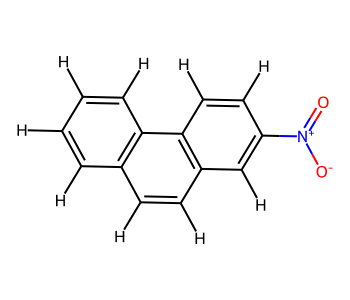

In [27]:
draw_molecule(mol0, explicit_hydrogens=True)

<h4 style="color:rgb(0,120,170)">Atom and bond indices</h4>

<p>One often needed information is the <i>atom number</i> of each atom in a given molecule or the <i>bond number</i>.

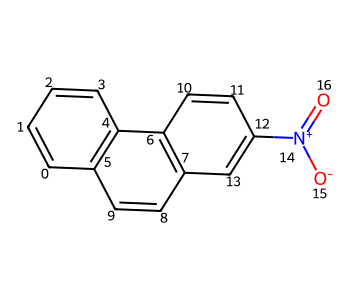

In [28]:
draw_molecule(mol0, atom_idcs=True)

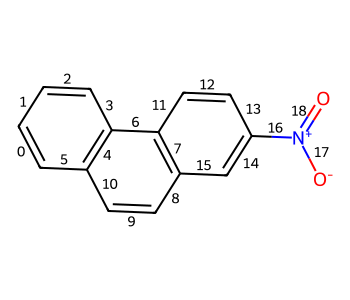

In [29]:
draw_molecule(mol0, bond_idcs=True)

<h4 style="color:rgb(0,120,170)">Atom, bond and ring information</h4>

Knowing the atom and bond indices are imporant for extracting and utilizing more interesting chemical properties such as 
- atomic number, i.e. the atom type (<code>GetAtomicNum</code>)
- the bond order/type (<code>GetBondType</code>)
- is an atom part of a ring (<code>IsInRing</code>)

Atom No.  0 with an atomic number of "6".
Atom No.  1 with an atomic number of "6".
Atom No.  2 with an atomic number of "6".
Atom No.  3 with an atomic number of "6".
Atom No.  4 with an atomic number of "6".
Atom No.  5 with an atomic number of "6".
Atom No.  6 with an atomic number of "6".
Atom No.  7 with an atomic number of "6".
Atom No.  8 with an atomic number of "6".
Atom No.  9 with an atomic number of "6".
Atom No. 10 with an atomic number of "6".
Atom No. 11 with an atomic number of "6".
Atom No. 12 with an atomic number of "6".
Atom No. 13 with an atomic number of "6".
Atom No. 14 with an atomic number of "7".
Atom No. 15 with an atomic number of "8".
Atom No. 16 with an atomic number of "8".


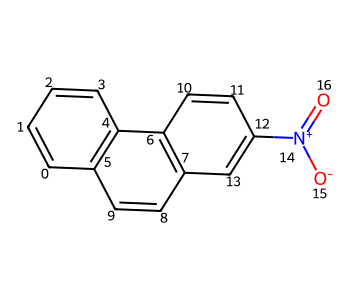

In [30]:
for atom in mol0.GetAtoms():
    print(f'Atom No. {atom.GetIdx():>2} with an atomic number of "{atom.GetAtomicNum()}".')

draw_molecule(mol0, atom_idcs=True)

Atom No.  0 is     in a ring.
Atom No.  1 is     in a ring.
Atom No.  2 is     in a ring.
Atom No.  3 is     in a ring.
Atom No.  4 is     in a ring.
Atom No.  5 is     in a ring.
Atom No.  6 is     in a ring.
Atom No.  7 is     in a ring.
Atom No.  8 is     in a ring.
Atom No.  9 is     in a ring.
Atom No. 10 is     in a ring.
Atom No. 11 is     in a ring.
Atom No. 12 is     in a ring.
Atom No. 13 is     in a ring.
Atom No. 14 is not in a ring.
Atom No. 15 is not in a ring.
Atom No. 16 is not in a ring.


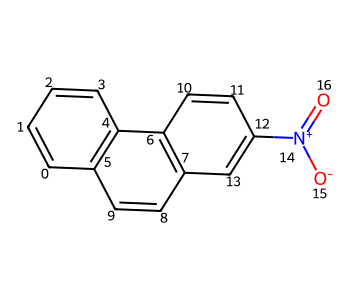

In [31]:
for atom in mol0.GetAtoms():
    print(f'Atom No. {atom.GetIdx():>2} is {"" if atom.IsInRing() else "not ":>4}in a ring.')

draw_molecule(mol0, atom_idcs=True)

Bond No.  0 is a bond of type AROMATIC
Bond No.  1 is a bond of type AROMATIC
Bond No.  2 is a bond of type AROMATIC
Bond No.  3 is a bond of type AROMATIC
Bond No.  4 is a bond of type AROMATIC
Bond No.  5 is a bond of type AROMATIC
Bond No.  6 is a bond of type AROMATIC
Bond No.  7 is a bond of type AROMATIC
Bond No.  8 is a bond of type AROMATIC
Bond No.  9 is a bond of type AROMATIC
Bond No. 10 is a bond of type AROMATIC
Bond No. 11 is a bond of type AROMATIC
Bond No. 12 is a bond of type AROMATIC
Bond No. 13 is a bond of type AROMATIC
Bond No. 14 is a bond of type AROMATIC
Bond No. 15 is a bond of type AROMATIC
Bond No. 16 is a bond of type SINGLE
Bond No. 17 is a bond of type SINGLE
Bond No. 18 is a bond of type DOUBLE


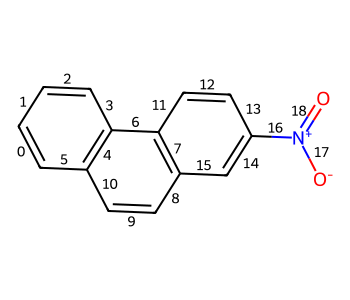

In [32]:
for bond in mol0.GetBonds():
    print(f'Bond No. {bond.GetIdx():>2} is a bond of type {bond.GetBondType()}')

draw_molecule(mol0, bond_idcs=True)

In the image bonds 0 and 1 look different: 0 seems to be a double-bond and 1 a single-bond. However, both of them have the type "AROMATIC".

[Aromaticity](https://en.wikipedia.org/wiki/Aromaticity) in organic chemistry describes the enhanced stability observed in cyclic arrangements of conjugated bonds, lone pairs, or empty orbitals, first coined by August Wilhelm Hofmann in 1855. This phenomenon, exemplified by benzene, arises from cyclic delocalization and resonance, allowing electrons to freely circulate within a ***ring of alternating single and double bonds***, resulting in greater stability than predicted solely by conjugation. 

Molecular graphs are a very natural way for humans to perceive and visualize molecules, but not the only way and often not the optimal way of storing molecules (tens of lines are needed for simple molecule) or to be modeled with ML approaches. Lets take look at represnation that better adapted for this tasks. 

<a name="molecule-data-nutshell-smiles"></a><h3 style="color:rgb(0,120,170)">SMILES</h3>
<p>The name of this data format is an abbreviation for <i><b>S</b>implified <b>M</b>olecular <b>I</b>nput <b>L</b>ine <b>E</b>ntry <b>S</b>pecification</i>. Molecules are herein represented as sequences of special tokens, denoting the <i>atoms</i> and the connectivity between the atoms.

Atoms are represented by single/double letter elements (*e.g.*, `C` for carbon, `Cl` for chloride), hydrogens are implicit and atoms part of an aromatic system are indicated with lower case letters. Single bonds are implicit, and double and triple bonds are represented by `=` and `#` respectively. Rings in the molecular structure are denoted by corresponding numbers, whereas side chains are denoted by brackets. 

One very important thing about SMILES representations is their <i>non-uniqueness</i>. Hence, a <i>single</i> molecule may have <i>multiple</i> SMILES representations.

<center>
    <img src="resources/smiles.png" alt="Image not found!"/>
</center>
    
This sketch demonstrates the extraction of one SMILES representation (<tt>D</tt>) of a specific molecule (<tt>A</tt>).</p>

Lets get some SMILES representations for our `mol0` compounds:

In [33]:
# Canonical SMILES (attempt to have an unique SMILES)
smi0 = Chem.MolToSmiles(mol0)

# Other smiles representation of the same molecule
smi1 = Chem.MolToSmiles(mol0, doRandom=True)
smi2 = Chem.MolToSmiles(mol0, doRandom=True)
smi0, smi1, smi2

('O=[N+]([O-])c1ccc2c(ccc3ccccc32)c1',
 'c1c2c(c3ccccc3cc2)ccc1[N+]([O-])=O',
 'c1c(cc2ccc3ccccc3c2c1)[N+](=O)[O-]')

By converting back these different SMILES to rdkit molecules and visualizing them we can check that correspond to the same molecule:

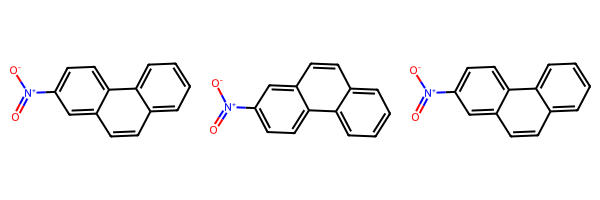

In [34]:
mols = [Chem.MolFromSmiles(smi) for smi in [smi0, smi1, smi2]] # Read each SMILES back to a rdkit molecule
Chem.Draw.MolsToGridImage(mols) # Visualize a set of rdkit molecules

Even tough the output image is not exactly the same for all three molecules from the SMILES, they still are the same molecule as the `N-C` bond is rotable.

<a name="fingerprints"></a><h3 style="color:rgb(0,120,170)">Molecular fingerprints</h3>

Nowdays, there are computational methods that are able directly work with molecular graphs (*e.g.*, GNNs - graph neural networks) or a string representations of the molecules (*e.g.*, RNNs), but generally ML and DL methods required a fixed lenght vector representation as input features.

**Molecular fingerprints** are molecular descriptors that encode molecular features/fragments/substructures of a molecule in the form of a binary vector. A bit is ON (or 1) of a certain fragment in found in a molecular structure. There are many different fingerprint algorithms. A commonly used method are the **Morgan fingeprints**  also known as circular fingerprints, are a type of molecular fingerprinting method used in cheminformatics and computational chemistry to represent the structural features of a molecule based on its atom environments within a given radius. These fingerprints encode information about the presence or absence of specific substructures.

<center>
    <img src="resources/ecfp.png" alt="Image not found!" width="250px" style="margin-right: 50px"/> <img src="resources/ecfp_folding.png" alt="Image not found!" width="600px"/>
</center>




Lets get the Morgan fingerprint for our `mol0` compound with radius 2 and fingerprint size of 512:

In [35]:
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=512)
mfpgen.GetFingerprint(mol0), mfpgen.GetFingerprintAsNumPy(mol0)

(<rdkit.DataStructs.cDataStructs.ExplicitBitVect at 0x7c27289ca110>,
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

This not a very human readable representation of a molecule, but something that computers like.

<a name="molecule-data-nutshell"></a><h2 style="color:rgb(0,120,170)">Visualizing molecular datasets</h2>

Here we have relative small dataset, so in principle we could visualize the molecular graph of each the molecules...

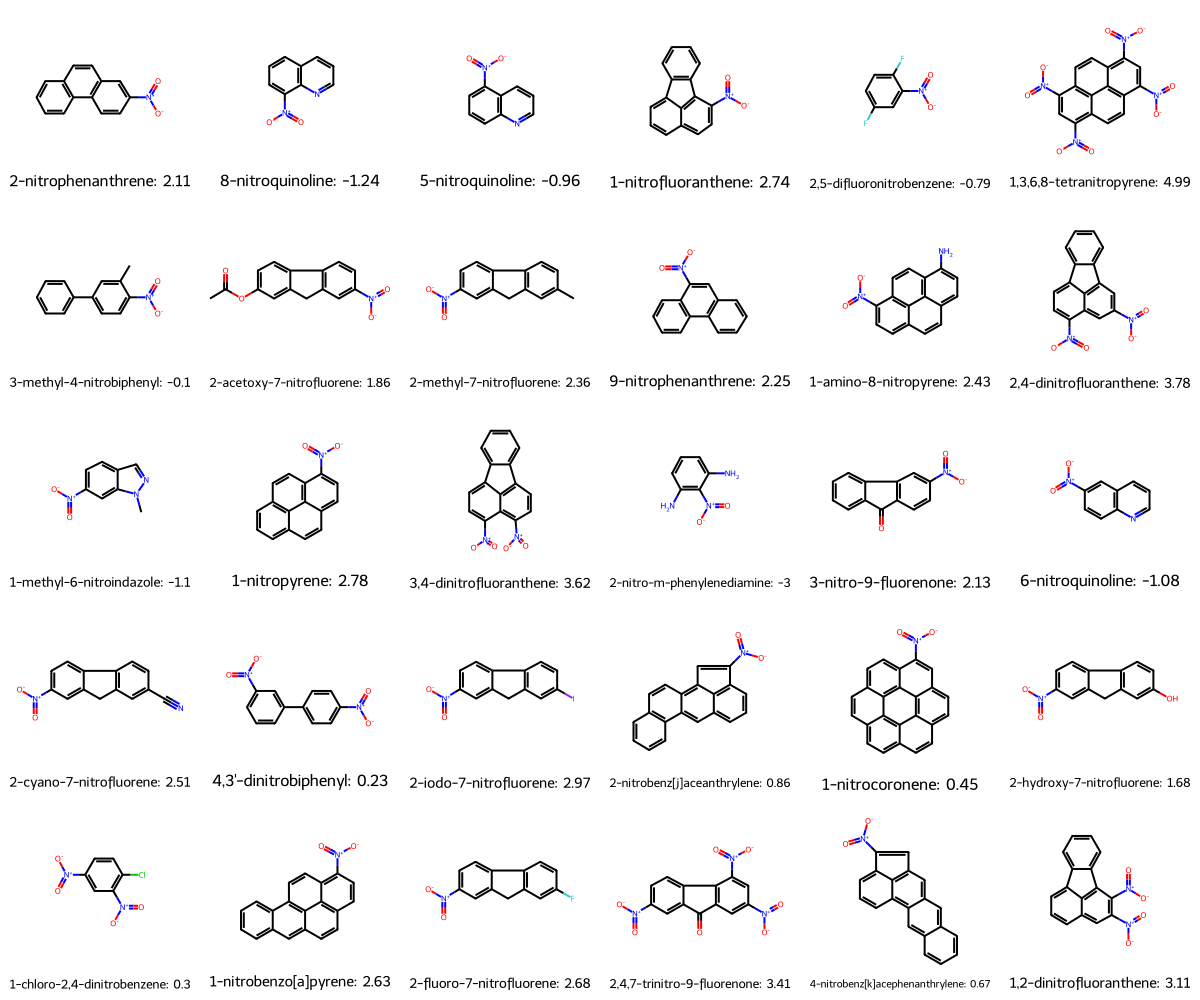

In [36]:
mols = [mol for mol in data_mutag]
labels = specific_molecule_labels = [f'{mol.GetProp("Compound Name")}: {mol.GetProp("Activity")}' for mol in mols]
n = 30 # len(mols)
Chem.Draw.MolsToGridImage(mols, molsPerRow=6, maxMols=n, legends=labels )

... but not very practical and its difficult to extract information from so many molecules. 

Lets try to get a more global view of the dataset. For this, we will calculate molecular fingerprints for all molecules in the dataset:

In [37]:
# Compute Morgan fingerprints for all mutag compounds
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=512)
fps = np.array([mfpgen.GetFingerprint(mol) for mol in data_mutag])
data_mutag_ecfp = pd.DataFrame(fps)
data_mutag_ecfp

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
216,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


We can get an idea of the diversity of the compounds by taking a look at fraction of molecules containing a feature: 

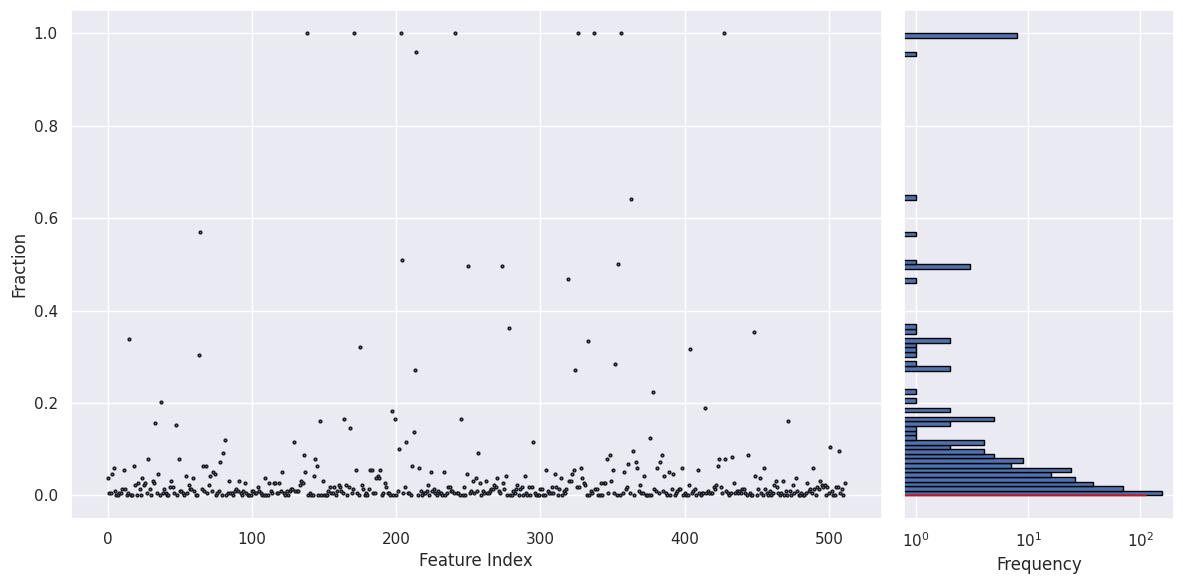

Average fraction of feature presence: 0.05
Average fraction of feature presence (w/ unpresent features): 0.07


In [38]:
u5.plot_feature_fractions(data_mutag_ecfp)
print(f'Average fraction of feature presence: {data_mutag_ecfp.mean().mean():.2f}')
print(f'Average fraction of feature presence (w/ unpresent features): {np.mean([x for x in data_mutag_ecfp.mean(axis=0) if x != 0]):.2f}')

The low average value of fractions of molecules containing a feature indicates a relative high diversity, as it indicates that most substructures are present in only few molecules. However, the fact that ~100 features are not present at all in the dataset and 8 features are present in all molecules, indicates a low diversity.

We can also apply dimensionality reduction to visualize our dataset:

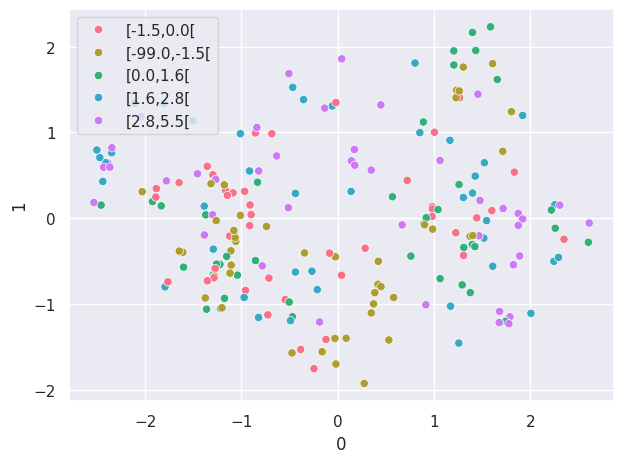

In [39]:
np.random.seed(seed=42)

# Apply PCA
data_mutag_ecfp_pca = u5.apply_pca(n_components=2, data=data_mutag_ecfp)
# Get 'Activity' value as target lables and bin them
activities = [float(mol.GetProp('Activity')) for mol in data_mutag]
binned_activities = u5.bin_contineous_label_values(activities)
# Plot the down projections
u5.plot_points_2d(data_mutag_ecfp_pca, targets=binned_activities)

Looking at this figure we can see two things:
1. There doesn't seems be a strong relationship between down projected fingerprints and the activity values of the molecules.
2. Most of the bins have a width of ~2 units, where as the first bin ranges for -99 to -1.5. 

Let's take a look at the distribution of activity value to see what is going on.

<Axes: ylabel='Count'>

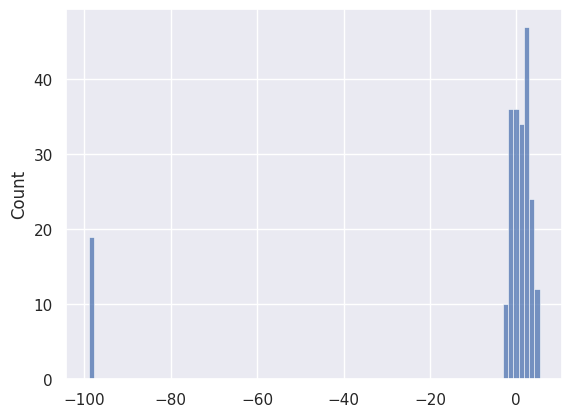

In [40]:
sns.histplot(activities)

In the distribution, we can see that we have 19 clear outliers in dataset. Probably, it was not possible to measure the activity of these compounds and they assumed to be very inactive, and thus assigned a very low value.

Lets futher investigate our dataset by clustering our fingerprints with the [sphere exclusion clustering](https://greglandrum.github.io/rdkit-blog/posts/2020-11-18-sphere-exclusion-clustering.html) method.

Number of clusters: 14


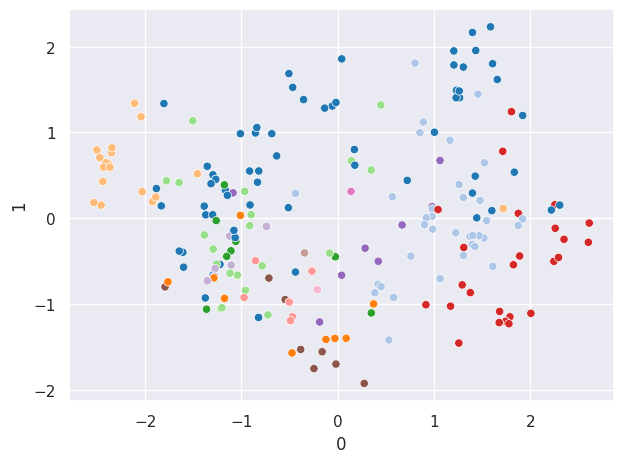

In [41]:
np.random.seed(seed=42)
clusters = u5.apply_sphere_exclusion_clustering(data=data_mutag_ecfp)
print('Number of clusters:', len(set(clusters)))
u5.plot_points_2d(data_mutag_ecfp_pca, targets=clusters, legend=False, multi_color_palette='tab20')

We can see that clusters are not very well separated in the in the PCA down projection, indicating that a significant amount of information was lost during the dimensionality reduction. 

Now we can inspect the molecules assigned to the same cluster. Do you see any similarities between them?

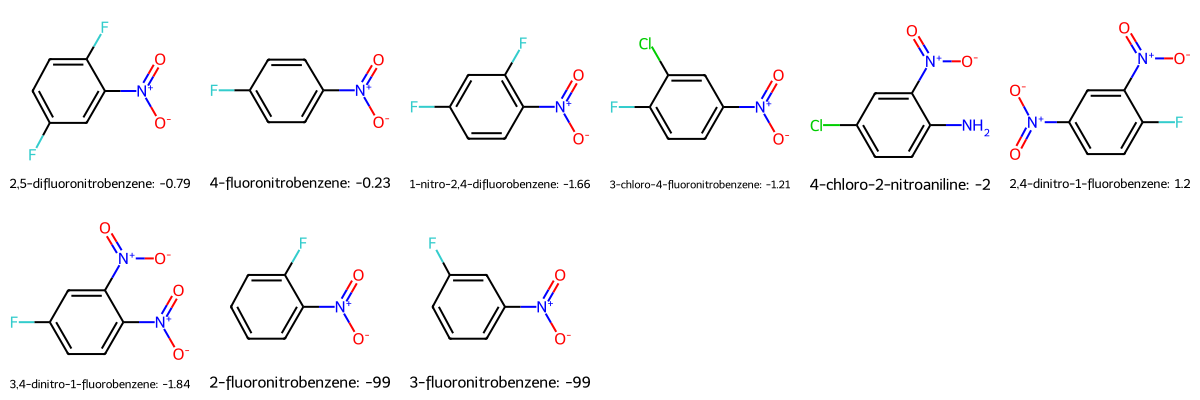

In [42]:
# Select specific molecules (here: based on k-means clustering and cluster with ID 2) and extract some of their properties.
cluster_indices = [i for i, cluster_id in enumerate(clusters) if cluster_id == 2]
cluster_molecules = [data_mutag[i] for i in cluster_indices]
cluster_molecule_labels = [f'{mol.GetProp("Compound Name")}: {mol.GetProp("Activity")}' for mol in cluster_molecules]

# Plot specified molecules with extracted properties as labels in a grid plot.
Chem.Draw.MolsToGridImage(
    cluster_molecules,
    legends=cluster_molecule_labels,
    maxMols=len(cluster_molecules),
    molsPerRow=6
)

<a name="qsar-modeling-practical"></a><h2 style="color:rgb(0,120,170)">QSAR Modeling </h2>

Now lets build a QSAR model to predict the mutagenesis activity of compounds.

<a name="qsar-modeling-practical-preprocess"></a><h3 style="color:rgb(0,120,170)">Preprocessing</h3>

We have already done most of the preprocessing as we have aleady compouted input features (the Morgan fingerprints) and extracted output labels (Activity values).

We also spotted some clear outliers when visualizing our dataset. Lets remove them from our data as they will just induce our models in error instead of providing useful information.

In [43]:
# Add the activities and Cluster information to the data_mutag_ecfp dataframe
data_mutag_ecfp['Activity'] = activities
data_mutag_ecfp['Cluster'] = clusters

# Remove all data point activity value below -50
data_mutag_ecfp = data_mutag_ecfp[data_mutag_ecfp.Activity > -50]
data_mutag_ecfp

,0,1,2,3,4,5,6,7,8,9,...,504,505,506,507,508,509,510,511,Activity,Cluster
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.11,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1.24,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.96,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,2.74,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.79,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.97,7
214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.02,7
215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.03,7
216,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,2.59,13


<a name="qsar-modeling-practical-split"></a><h3 style="color:rgb(0,120,170)">Cluster split</h3>

In contrast to other machine learning domains such as vision and natural language processing, where data often follows the assumption of independence and identical distribution (i.i.d.), QSAR data presents a unique challenge. QSAR datasets frequently exhibit compound series bias, wherein sets of closely related compounds are synthesized and tested together, often with minor variations in molecular structure.

Consequently, traditional random data splits for model evaluation can lead to inflated performance estimates, as these splits may inadvertently include highly similar compounds in both the training and testing sets. To mitigate this bias, a cluster-based splitting strategy is commonly employed, wherein molecules belonging to the same chemical series are grouped together and assigned to either the training or testing subset. This approach more accurately reflects the real-world scenario and provides a more reliable estimation of model performance on unseen compounds.

In [44]:
data_train, data_test = u5.apply_cluster_split(data_mutag_ecfp, test_size=0.25)
print(f'Train set size:\t {data_train.shape[0]}\t ({data_train.shape[0]/(data_mutag_ecfp.shape[0]):.2f})')
print(f'Test set size:\t {data_test.shape[0]}\t ({data_test.shape[0]/(data_mutag_ecfp.shape[0]):.2f})')

Train set size:	 153	 (0.77)
Test set size:	 46	 (0.23)


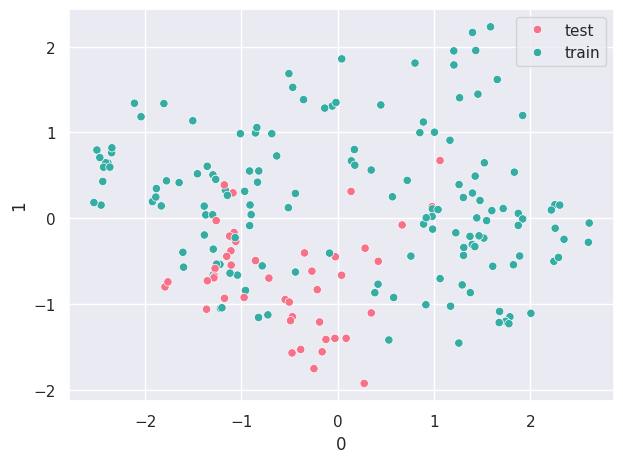

In [45]:
labels = ['train' if i in data_train.index else 'test' for i in data_mutag_ecfp.index]
u5.plot_points_2d(data_mutag_ecfp_pca.loc[data_mutag_ecfp.index], targets=labels)


<a name="qsar-modeling-practical-split"></a><h3 style="color:rgb(0,120,170)">Regression model</h3>

Now, we embark on constructing a machine learning-based QSAR model tailored for activity predictions. We will use a simple <code>KNeighborsRegressor</code> model here.

It's crucial to note that in the virtual screening of extensive datasets, the ranking of compounds holds greater significance than the precise predicted values. As a result, we opt to utilize the <a href="https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient">Spearman rank correlation coefficient</a> as our evaluation metric. This metric provides insights into how well the model preserves the ranking order of compounds based on their predicted activities, which aligns more closely with the priorities of virtual screening tasks.

Train spearmanr_score: 0.780
Test spearmanr_score: 0.318


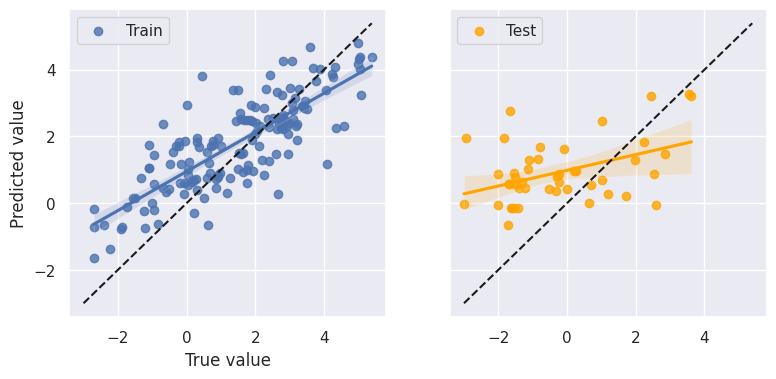

In [50]:
_ = u5.train_and_evaluate_sklearn_regressor(
    model = KNeighborsRegressor(),
    X_train=data_train.drop(['Activity', 'Cluster'], axis=1).values,
    y_train=data_train['Activity'].values,
    X_test=data_test.drop(['Activity', 'Cluster'], axis=1).values,
    y_test=data_test['Activity'].values,
    metric = u5.spearmanr_score,
)

We have model that has quite poor performance that is neither able to predict training set datapoint correctly and doesn't generalize well to the test set. Maybe we can improve it with some hyperparameter optimization:

In [47]:
hyperparams = {
    'neighbors' : [2,4,6,8],                        # Number of neighbors
    'weights' : ['uniform', 'distance'],            # Weight of each neighbor
    'distance' : ['euclidean', 'manhattan'],        # Distance metric
    'feature_variance': [None, 0.00, 0.01, 0.05]    # Thresholds to drop features with low variance
}

hyperparams_comb_list = list(ParameterGrid(hyperparams))
print('Number of hyperparameter combinations:', len(hyperparams_comb_list))
print('First combination:', hyperparams_comb_list[0])

Number of hyperparameter combinations: 64
First combination: {'distance': 'euclidean', 'feature_variance': None, 'neighbors': 2, 'weights': 'uniform'}


In [48]:
best_test_error = -100
best_hparams = {}

# Extract training and test data in to a tuple
data = (
    data_train.drop(['Activity', 'Cluster'], axis=1).values,
    data_train['Activity'].values,
    data_test.drop(['Activity', 'Cluster'], axis=1).values,
    data_test['Activity'].values,
)

# Iterate over hyperparameter combinations
for hps in hyperparams_comb_list:
    
    # Create model
    model = KNeighborsRegressor(
        n_neighbors=hps['neighbors'],
        weights=hps['weights'],
        metric=hps['distance'],
    )

    # Train and evaluate
    _, _, _, test_error = u5.train_and_evaluate_sklearn_regressor(
        model, 
        *data,
        low_variance_feature_th=hps['feature_variance'],
        plot = False,
        verbose = False,
        metric = u5.spearmanr_score,
    )   

    # Check if current model is the best   
    if test_error > best_test_error:
        print(test_error, hps)
        best_test_error = test_error
        best_hparams = hps

0.5016290007433255 {'distance': 'euclidean', 'feature_variance': None, 'neighbors': 2, 'weights': 'uniform'}
0.5228709789353743 {'distance': 'euclidean', 'feature_variance': None, 'neighbors': 2, 'weights': 'distance'}
0.6103988706518297 {'distance': 'euclidean', 'feature_variance': 0.01, 'neighbors': 2, 'weights': 'uniform'}
0.6192664798282174 {'distance': 'euclidean', 'feature_variance': 0.01, 'neighbors': 2, 'weights': 'distance'}


Number of features: 216
Train spearmanr_score: 0.998
Test spearmanr_score: 0.619


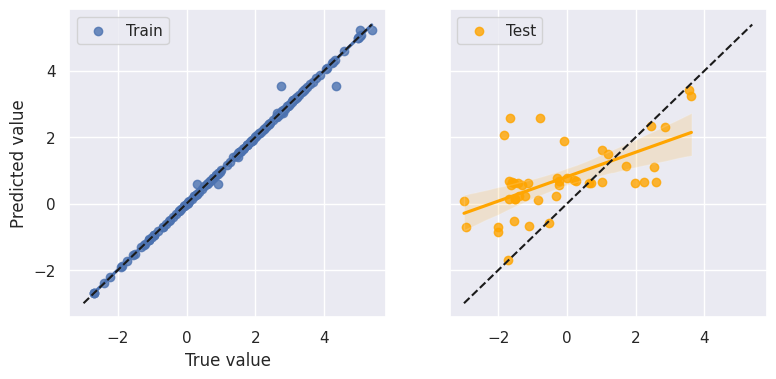

In [49]:
model = KNeighborsRegressor(
    n_neighbors=best_hparams['neighbors'],
    weights=best_hparams['weights'],
    metric=best_hparams['distance'],
)

_ = u5.train_and_evaluate_sklearn_regressor(
    model,
    *data,
    low_variance_feature_th=best_hparams['feature_variance'],
    metric = u5.spearmanr_score,
)  

<a name="teacheopencadd"></a><h2  style="color:rgb(0,120,170)">TeachOpenCADD</h2>

If this notebook has sparked your interest in applying computational tools and machine learning to molecules and drug discovery, we can recommend you an excelent series of Talktorials for compter-aided drug discovery at <a href="https://github.com/volkamerlab/teachopencadd">TeachOpenCADD</a>.